Change the kernel to __newautoriftenv__.

In [3]:
import rasterio as rio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from scipy.interpolate import interp2d

In [19]:
basepath = '/Volumes/SGlacier/surge_projects/OGSGlacier/2019_rd/Resampled/March_2019r/'
os.listdir(basepath)

['20190321_182951_1020_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190308_200752_0f3f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190307_183149_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190324_182655_104b_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190327_201337_0f34_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190321_200748_1003_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190324_201701_83_1059_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190325_182501_100d_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190308_200412_0e0f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '.DS_Store',
 '20190329_201201_101f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190324_182653_104b_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190308_200753_0f3f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190324_182654_104b_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190307_183148_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190325_200637_0f35_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190325_200518_1021_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190321_182950_1020_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190330_200

# Coregister and stitch all Planet tiles for each image date

In [20]:
# grab unique dates
filelist = os.listdir(basepath); filelist.sort()
unique_dates = []
for file in filelist:
    if file.startswith('2') and file.endswith('tif'):
        date = file[:8]
        unique_dates.append(date)
sorted_dates = list(set(unique_dates))
sorted_dates.sort()
print(sorted_dates)

['20190304', '20190307', '20190308', '20190311', '20190321', '20190324', '20190325', '20190326', '20190327', '20190329', '20190330']


In [21]:
# Grab the first Planet tile for reference CRS and Transform
files = []
for file in filelist:
    if file.endswith('.tif'):
        files.append(file)
reftile = rio.open(basepath+files[0])
print(reftile.crs)
reftile.transform

EPSG:32607


Affine(4.979215074031483, 0.0, 552405.7509554505,
       0.0, -4.97921507403153, 6675752.108247815)

TILES FOR 20190304
20190304_201426_72_105f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.5170467581949132
20190304_201428_77_105f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2752648123460929
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.24858177245110272
Smaller coregistered: 0.09917309022690993
Larger: 0.2752648123460929


20190304_201430_83_105f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2989969957584455
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.044189078952336105
Smaller coregistered: 0.19295266294145091


/var/folders/0n/g39xfc553hdfgh41ghm191m80000gq/T/ipykernel_1307/1795061443.py:74: RuntimeWarning: Mean of empty slice
  print('Larger:',np.nanmean(larger_tile))


Larger: nan




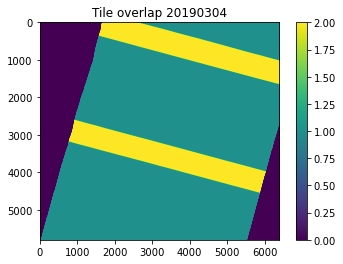

Overlapping tiles were coregistered.


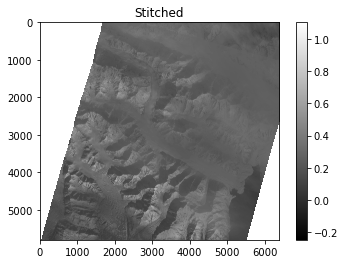

TILES FOR 20190307
20190307_183148_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.09124769338031394
20190307_183149_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.15569216389867238
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.027386075867311076
Smaller coregistered: 0.10101881109736972
Larger: 0.15569216389867238


20190307_183150_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.16729166312781515
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.005211272554024094
Smaller coregistered: 0.0
Larger: 0.16723812065220722


20190307_183151_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.10937550117334405
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.05362337655341561
Smaller coregistered: 0.0
Larger: 0.10988097882326509


20190307_183152_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.13038625052799602
Previous tile is larger.
Mean diff

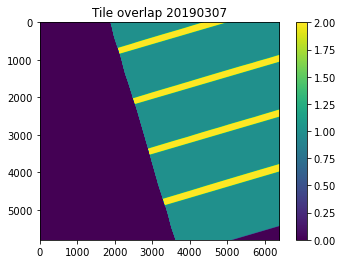

Overlapping tiles were coregistered.


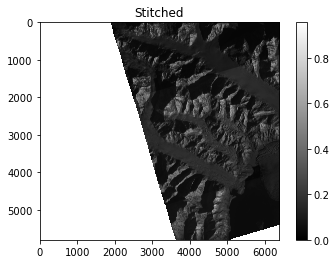

TILES FOR 20190308
20190308_182955_104a_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2412668091075906
20190308_182956_104a_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.08067370911858746
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 0.1639120038531067
Smaller coregistered: 0.21518937460670967
Larger: 0.2412668091075906


20190308_182957_104a_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.11161271003362397
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 0.005267416385929833
Smaller coregistered: 0.10535582274348232
Larger: nan


20190308_182958_104a_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.10798568711275401
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.00018996048542940146
Smaller coregistered: 0.0889191278124939
Larger: nan


20190308_200409_0e0f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.09603601917257687
Current tile is larger.
Mean diffe

/var/folders/0n/g39xfc553hdfgh41ghm191m80000gq/T/ipykernel_1307/1795061443.py:60: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(np.subtract(overlap_values_larger,overlap_values_smaller)) # mean diff


Mean difference in values from the larger tile in overlap area: nan


/var/folders/0n/g39xfc553hdfgh41ghm191m80000gq/T/ipykernel_1307/1795061443.py:73: RuntimeWarning: Mean of empty slice
  print('Smaller coregistered:',np.nanmean(masked_smaller_tile_coreg))


Smaller coregistered: nan
Larger: nan


20190308_200751_0f3f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.4096639741511637
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.16626790721053433
Smaller coregistered: 0.0
Larger: 0.4202413271567491


20190308_200752_0f3f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.45089249198873804
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.10349300355091882
Smaller coregistered: 0.0
Larger: 0.38526427082897674


20190308_200753_0f3f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.41833983252415063
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 0.030180081277205437
Smaller coregistered: 0.13539145119881002
Larger: nan




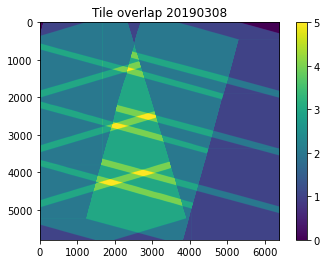

Overlapping tiles were coregistered.


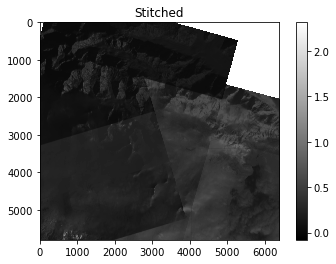

TILES FOR 20190311
20190311_200243_0e2f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.4399872703509114


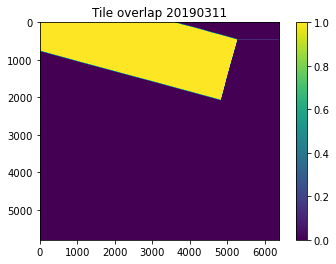

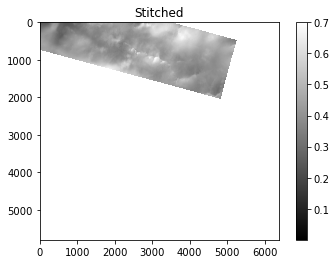

TILES FOR 20190321
20190321_182950_1020_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2935810943398151
20190321_182951_1020_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.3761341713630802
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.00016853848541765567
Smaller coregistered: 0.20979336667419998
Larger: 0.3761341713630802


20190321_182952_1020_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.09297753925017159
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.33934535181093617
Smaller coregistered: 0.0
Larger: 0.0944204114532186


20190321_182953_1020_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.11431573062361956
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.006714974825327807
Smaller coregistered: 0.09523880855617813
Larger: nan


20190321_182954_1020_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.1065374527770976
Previous tile is larger.
Mean differ

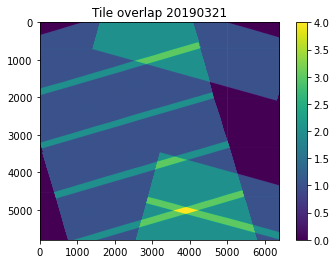

Overlapping tiles were coregistered.


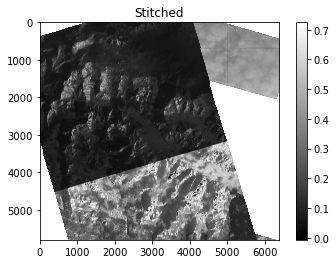

TILES FOR 20190324
20190324_182653_104b_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2716718621759939
20190324_182654_104b_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.5561117277894597
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.11567648609571708
Smaller coregistered: 0.324601379173376
Larger: 0.5561117277894597


20190324_182655_104b_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.5720321984366669
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.02005203072469936
Smaller coregistered: 0.0
Larger: 0.5743102302874419


20190324_182656_104b_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.265645924274933
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 0.36563217992347746
Smaller coregistered: 0.5470758561008535
Larger: nan


20190324_183023_104a_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.41999747698844386
Previous tile is larger.
Mean difference in val

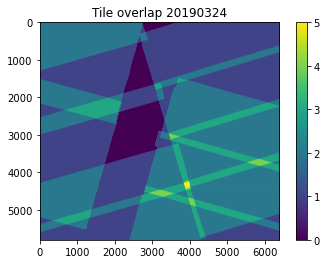

Overlapping tiles were coregistered.


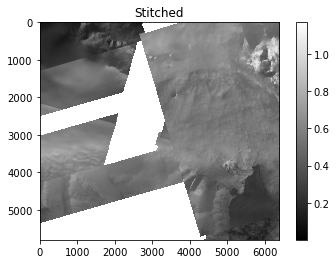

TILES FOR 20190325
20190325_182501_100d_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.22469528426229152
20190325_182502_100d_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.473064644969707
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.032566675645837456
Smaller coregistered: 0.20568759651787863
Larger: 0.473064644969707


20190325_194909_46_1062_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2695123648098046
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.24387030680115468
Smaller coregistered: 0.0
Larger: 0.27237125117831396


20190325_194911_55_1062_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.4496465796251237
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.11843719978893477
Smaller coregistered: 0.2707438164809588
Larger: nan


20190325_194913_64_1062_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.3831756347904079
Previous tile is larger.
Mean dif

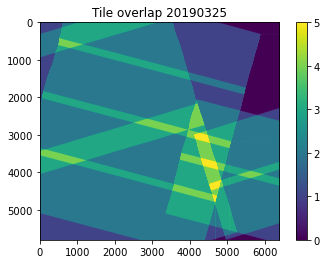

Overlapping tiles were coregistered.


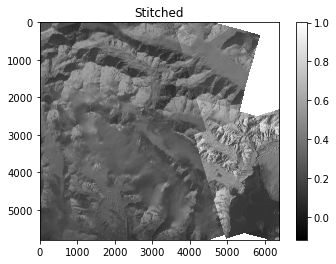

TILES FOR 20190326
20190326_200535_103d_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.44189720946766403
20190326_200536_103d_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.21244907562314544
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.07618259794337837
Smaller coregistered: 0.3360753944935601
Larger: 0.21244907562314544


20190326_201259_1011_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.3107357052794538
20190326_201300_1011_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.47824714610642255
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.12785236982775017
Smaller coregistered: 0.34192780189302485
Larger: 0.47824714610642255


20190326_201301_1011_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.41107531717568796
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 5.178729094479813e-06
Smaller coregistered: 0.36041273452907036
Larger: nan




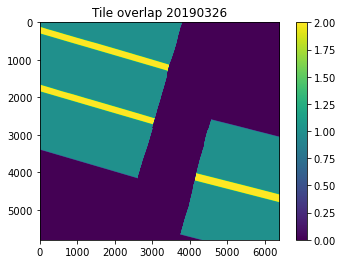

Overlapping tiles were coregistered.


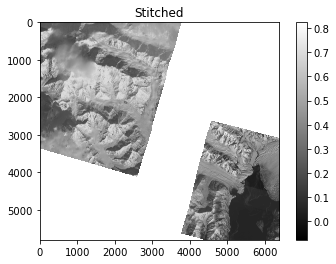

TILES FOR 20190327
20190327_201335_0f34_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2581637747378559
20190327_201336_0f34_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.22604699406917197
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.02849011377947257
Smaller coregistered: 0.20536788559410168
Larger: 0.22604699406917197


20190327_201337_0f34_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.26306205227868196
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.07866197350361359
Smaller coregistered: 0.1634538362276997
Larger: nan


20190327_201338_0f34_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2759255227681523
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.02626975901392456
Smaller coregistered: 0.21901456673420563
Larger: nan


20190327_202140_79_1060_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.28275743326405656
Previous tile is larger.
Mean dif

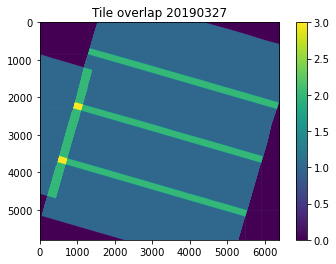

Overlapping tiles were coregistered.


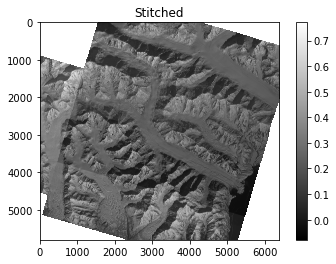

TILES FOR 20190329
20190329_200518_1009_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.3202194161244536
20190329_200820_1021_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.30180354176881147
20190329_200821_1021_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.3763609869199104
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.10525939162937083
Smaller coregistered: 0.2310551470673843
Larger: 0.30180354176881147


20190329_201201_101f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.292405121630926
Current tile is larger.
Mean difference in values from the larger tile in overlap area: nan
Smaller coregistered: nan
Larger: 0.3034252335772966


20190329_201202_101f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.30245774873795944
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.010530745727060116
Smaller coregistered: 0.0
Larger: 0.3116734651082092


20190329_201203_101f_3B_AnalyticMS_SR_clip_5m_mv.tif save

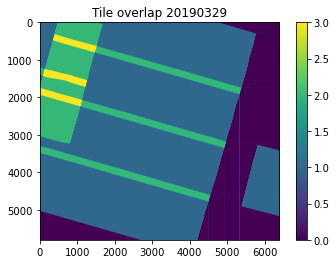

Overlapping tiles were coregistered.


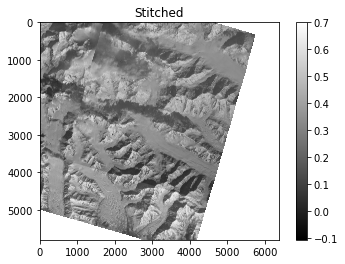

TILES FOR 20190330
20190330_200635_1039_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.36772357154170193
20190330_200636_1039_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.35876336480709337
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.0033667965382005154
Smaller coregistered: 0.3278389882479111
Larger: 0.35876336480709337


20190330_200637_1039_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.3127959312833088
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.014012681939537492
Smaller coregistered: 0.0
Larger: 0.30854267839464333


20190330_200638_1039_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.31966710044097946
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.021231066475706134
Smaller coregistered: 0.25894453651318516
Larger: nan


20190330_201055_0f4e_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.2939786599276817
Previous tile is larger.
Mean diffe

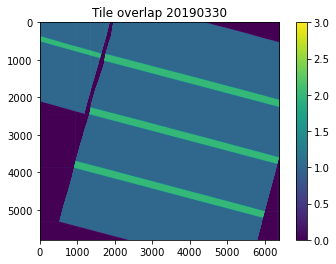

Overlapping tiles were coregistered.


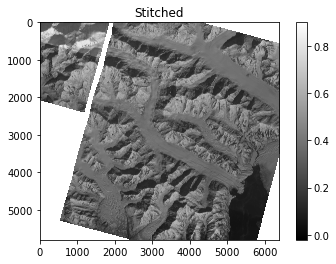

In [37]:
for date in sorted_dates:  
    print('TILES FOR '+date)
    # Grab the Planet tiles corresponding to each unique date
    tiles = []
    for file in filelist:
        if file.startswith(date) and file.endswith('.tif'):
            tiles.append(file)
    tiles.sort() # sort tilenames alphanumeric order
    
    # initialize empty arrays
    sr_originals = []; sr_coregistered = []; sr_binary = []
    overlap_total = np.zeros(reftile.shape); total_coverage = np.zeros(reftile.shape).astype(bool)
    t = 0 # tile count
    for tile in tiles:
        reader = rio.open(basepath+tile); sr = reader.read(1) 
        sr_orig = sr.copy(); sr_originals.append(sr_orig) # store the original tile
        sr[sr>0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
        sr_data = sr_orig # use the original tile as the data

        # use binary mask to calculate overlap area
        overlap_total = overlap_total+sr # add to calculate overlap
        tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
        overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # total overlap area
            
        print(tile, 'saved. Mean: ',np.nanmean(sr_data)); # Plot!
#             plt.imshow(sr_orig,cmap='gray'); plt.title('Tile'); plt.colorbar(); plt.show()
    
        if t >= 1: # start comparisons with the second tile
                
#             fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) # Plot!
#             im1 = ax1.imshow(sr_data_prev,cmap='gray'); ax1.set_title('Previous tile'); fig.colorbar(im1, ax=ax1)
#             im2 = ax2.imshow(sr_data,cmap='gray'); ax2.set_title('Tile'); fig.colorbar(im2, ax=ax2); plt.show()
            
            # Determine each pair of tiles' overlap
            if overlap_area > prev_overlap: # increase in overlapping area indicates we have 2 overlapping tiles!!!
                overlap2 = sr_prev+sr # calculate the overlap between just these two
                overlap_band = ma.masked_less(overlap2, 2) # mask out non-overlapping area
                overlap_band_mask = ma.getmaskarray(overlap_band) # grab the mask for the overlapping area
                
                # grab the current coverage of the 2 tiles
                combined_coverage = ma.masked_greater_equal(overlap2, 1) # get rid of anything less than 1
                coverage_mask = ma.getmaskarray(combined_coverage) # grab the mask
            
                # identify which tile is larger
                if tilesize > prev_tilesize:
                    print('Current tile is larger.')
                    larger_tile = sr_data; smaller_tile = sr_data_prev # assign the tiles
                elif tilesize < prev_tilesize:
                    print('Previous tile is larger.')
                    larger_tile = sr_data_prev; smaller_tile = sr_data # assign the tiles
                else: # equal sizes
                    print('Tiles are the same size.')
                    larger_tile = sr_data; smaller_tile = sr_data_prev # use current tile to coregister
                    
                # grab pixel values from overlapping area from both tiles
                overlap_values_l = ma.masked_where(overlap_band_mask, larger_tile)
                overlap_values_larger = ~overlap_values_l.mask*overlap_values_l.data
                overlap_values_s = ma.masked_where(overlap_band_mask, smaller_tile)
                overlap_values_smaller = ~overlap_values_s.mask*overlap_values_s.data
                mean_diff = np.nanmean(np.subtract(overlap_values_larger,overlap_values_smaller)) # mean diff
                print('Mean difference in values from the larger tile in overlap area:',mean_diff)

                # coregister the smaller tile's values to the larger reference tile's overlap values
                smaller_tile_coreg = smaller_tile + mean_diff # add the mean difference to all values
                smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile_coreg) 
                
                # with overlap removed:
                larger_tile = ma.masked_where(total_coverage,larger_tile)
                masked_larger_tile = ~larger_tile.mask*larger_tile.data
                smaller_tile_coreg = ma.masked_where(total_coverage, smaller_tile_coreg)
                masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
                
                print('Smaller coregistered:',np.nanmean(masked_smaller_tile_coreg))
                print('Larger:',np.nanmean(larger_tile))
                print(); print();
                  
                # over-write into co-registered files
                sr_coregistered.append(masked_smaller_tile_coreg)
                sr_coregistered.append(masked_larger_tile)
                total_coverage = ma.mask_or(total_coverage, coverage_mask) # add to coverage to total coverage
            
        # Store tile info for the next round of comparison
        prev_overlap = overlap_area # amount of pixels overlapping
        prev_tile = tile
        prev_tilesize = tilesize # previous tile size (pixels w/ data)
        sr_data_prev = sr_data
        sr_prev = sr
        t += 1 # increment tile count
        
    # Evaluate overlap between between all scenes
    fig = plt.figure(); im = plt.imshow(overlap_total); fig.colorbar(im); plt.title('Tile overlap '+date); plt.show()
    total_overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # overlapping areas will have >= 2
    stitched = np.zeros(sr.shape) # intialize stitched array
    if total_overlap_area > 0: # if there was overlap
        print('Overlapping tiles were coregistered.')
        stitched = np.nansum(sr_coregistered,0) # sum all coregistered (along slices)
    else: # if no overlap between any of the tiles
        stitched = np.nansum(sr_originals,0) # sum all (along slces)
    stitched[stitched == 0]=np.NaN # fill in with NaNs
    fig = plt.figure(); im = plt.imshow(stitched, cmap='gray'); plt.title('Stitched'); fig.colorbar(im); plt.show()
    
    # Export stitched image
    outfilename = 'PS_'+date+'.tif'
    with rio.open(basepath+outfilename,'w',
                      driver='GTiff',
                      height=stitched.shape[0], # new shape
                      width=stitched.shape[1], # new shape
                      dtype=stitched.dtype, # data type
                      count=1,
                      crs=reftile.crs, # the EPSG from the original DEM
                      transform=reftile.transform) as dst:
            dst.write(stitched, 1)
            
#     break
    del sr_coregistered; del sr_originals; del total_coverage; del overlap_total; del sr_binary;
    

# Crop images to Turner Glacier's box

In [228]:
boxpath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner_UTM_07.shp' # path to shapefile

# clip all stitched files
for file in os.listdir(basepath):
    if file.startswith('PS') and file.endswith('.tif') and 'clipped' not in file:
        date = file[3:11]; print(date)
        
        # if the clipped version doesn't already exist
        if not file[:-4]+'_clipped.tif' in os.listdir(basepath): 
#             print(file)
            # Crop file
            crop_cmd = 'gdalwarp -cutline '+boxpath+' -crop_to_cutline '
            crop_cmd += basepath+file+' '+basepath+file[:-4]+'_clipped.tif'
            print(crop_cmd); print()

            subprocess.run(crop_cmd,shell=True,check=True); print()


20190304
20190307
